In [1]:
import sys, os
sys.path.append('/cr/users/filip/bin/')

# from utils.Auger.SD import Monitoring

from utils.binaries import *
from utils.plotting import *

def is_winter_night(df):
    mask = []
    for _, row in df.iterrows():
        t = row['t']

        if t.month not in [6, 7]: 
            mask.append(False)
            continue
        if not (0 <= t.hour < 6): 
            mask.append(False)
            continue

        mask.append(True)

    return mask

def is_summer_day(df):
    mask = []
    for _, row in df.iterrows():
        t = row['t']

        if t.month not in [1, 12]: 
            mask.append(False)
            continue
        if not (12 <= t.hour < 18): 
            mask.append(False)
            continue

        mask.append(True)

    return mask

15:16:25 (  +24.7s) [INFO   ] -- import logging
15:16:25 (  +167ms) [INFO   ] -- import numpy as np
15:16:25 (   +12ms) [INFO   ] -- import uncertainties
15:16:26 (  +629ms) [INFO   ] -- import pandas as pd
15:16:26 (    +5ms) [WARNING] -- pandas support to be dropped at some point!
15:16:26 (    +6ms) [INFO   ] -- import binaries.tools as tools
15:16:27 (  +768ms) [INFO   ] -- import matplotlib.pyplot as plt
15:16:27 (  +855ms) [INFO   ] -- import seaborn as so
15:16:27 (   +24ms) [DEBUG  ] -- font size set to 9.5
15:16:27 (    +3ms) [DEBUG  ] -- label size set to 13.0
15:16:27 (    +2ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
15:16:27 (   +12ms) [DEBUG  ] -- markersize set to 2.0
15:16:27 (    +3ms) [DEBUG  ] -- usetex set to False
15:16:27 (    +3ms) [INFO   ] -- import plotting.tools as plot


In [2]:
import datetime

GPS_OFFSET = 315964800
data = pd.read_csv('/cr/tempdata01/filip/SSDCalib/BootstrapHistos/estimates.txt', sep=' ', index_col=False)
data = data.dropna()

data['id'] = data['id'].astype(str)
data['t'] = [datetime.datetime.fromtimestamp(d + GPS_OFFSET) for d in data['t']]

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

stations = np.unique(data['id'])

In [3]:
container = []
container_summer = []
container_winter = []

summer = data[is_summer_day(data)]
winter = data[is_winter_night(data)]
least_data_points = 30

for station in stations:
    df = data[data["id"] == station]
    df_summer = summer[summer["id"] == station]
    df_winter = winter[winter["id"] == station]
    mip_and_sigma_and_bias = [station, df['mip'].mean()]
    mip_and_sigma_and_bias_summer = [station, df_summer['mip'].mean()]
    mip_and_sigma_and_bias_winter = [station, df_winter['mip'].mean()]

    for col in data.columns[3:]:
            mip_and_sigma_and_bias.append([df[col].mean(), df[col].std()])
            mip_and_sigma_and_bias_summer.append([df_summer[col].mean(), df_summer[col].std()])
            mip_and_sigma_and_bias_winter.append([df_winter[col].mean(), df_winter[col].std()])

    if len(df) >= least_data_points:
        container.append(mip_and_sigma_and_bias)
    if len(df_summer) >= least_data_points:
        container_summer.append(mip_and_sigma_and_bias_summer)
    if len(df_winter) >= least_data_points:
        container_winter.append(mip_and_sigma_and_bias_winter)

performance = pd.DataFrame(container, columns=['id', 'mip', *data.columns[3:]])
performance_summer = pd.DataFrame(container_summer, columns=performance.columns)
performance_winter = pd.DataFrame(container_winter, columns=performance.columns)

15:29:52 ( +804.4s) [DEBUG  ] -- font size set to 9.5
15:29:52 (    +1ms) [DEBUG  ] -- label size set to 13.0
15:29:52 (    +2ms) [DEBUG  ] -- figure size set to [3.3, 2.5]
15:29:52 (    +1ms) [DEBUG  ] -- markersize set to 2.0
15:29:52 (    +1ms) [DEBUG  ] -- usetex set to True
15:29:52 (    +2ms) [DEBUG  ] -- using dark mode!


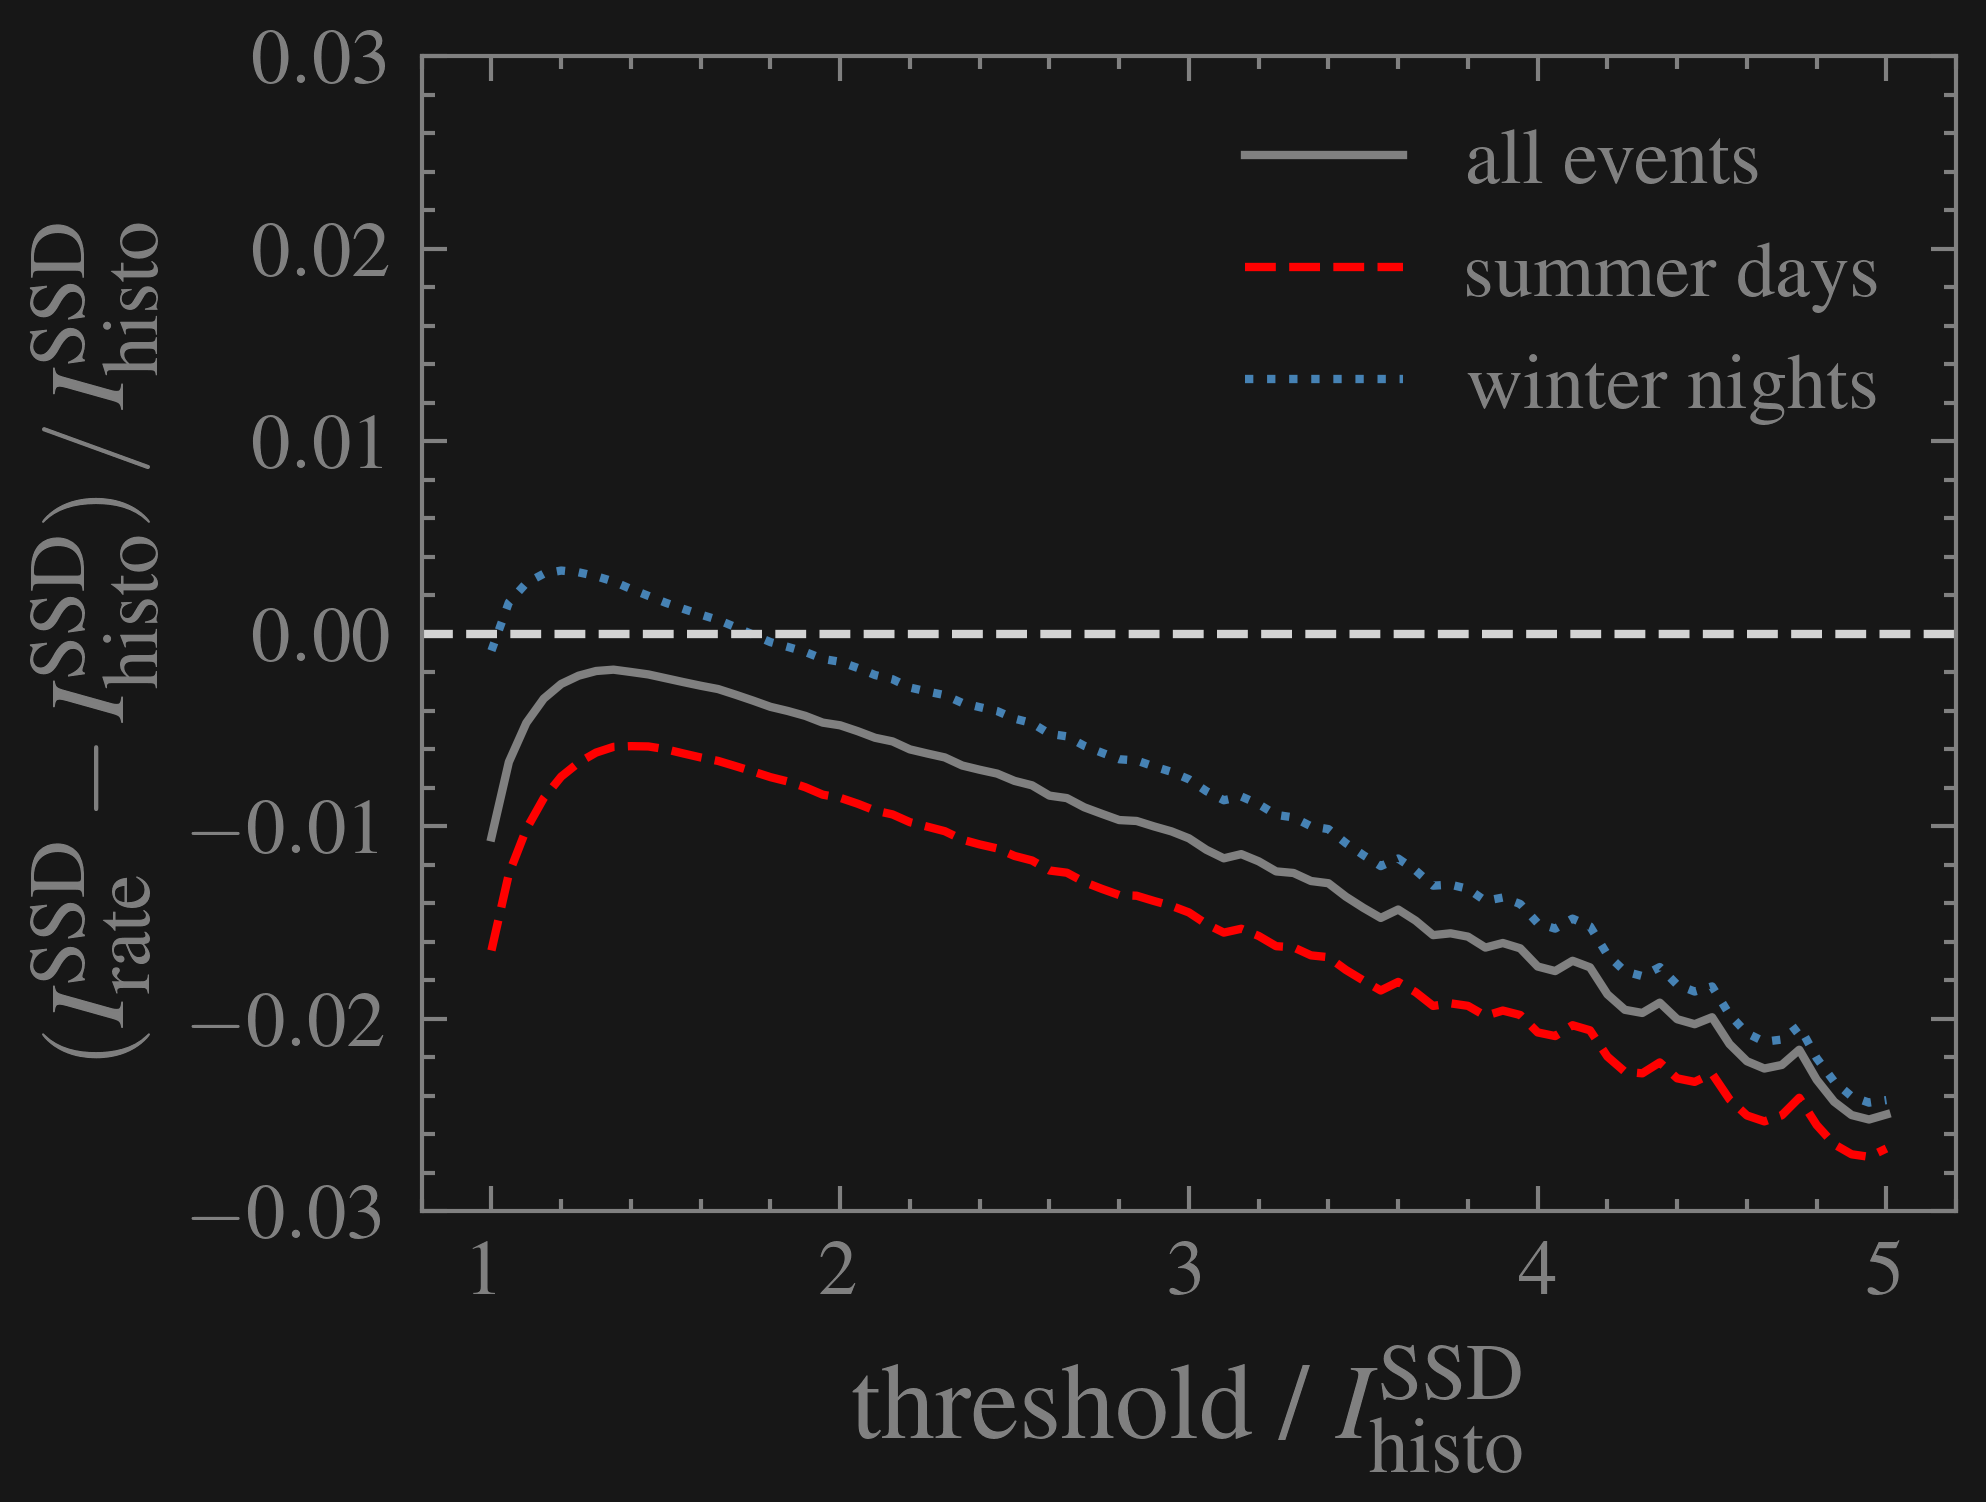

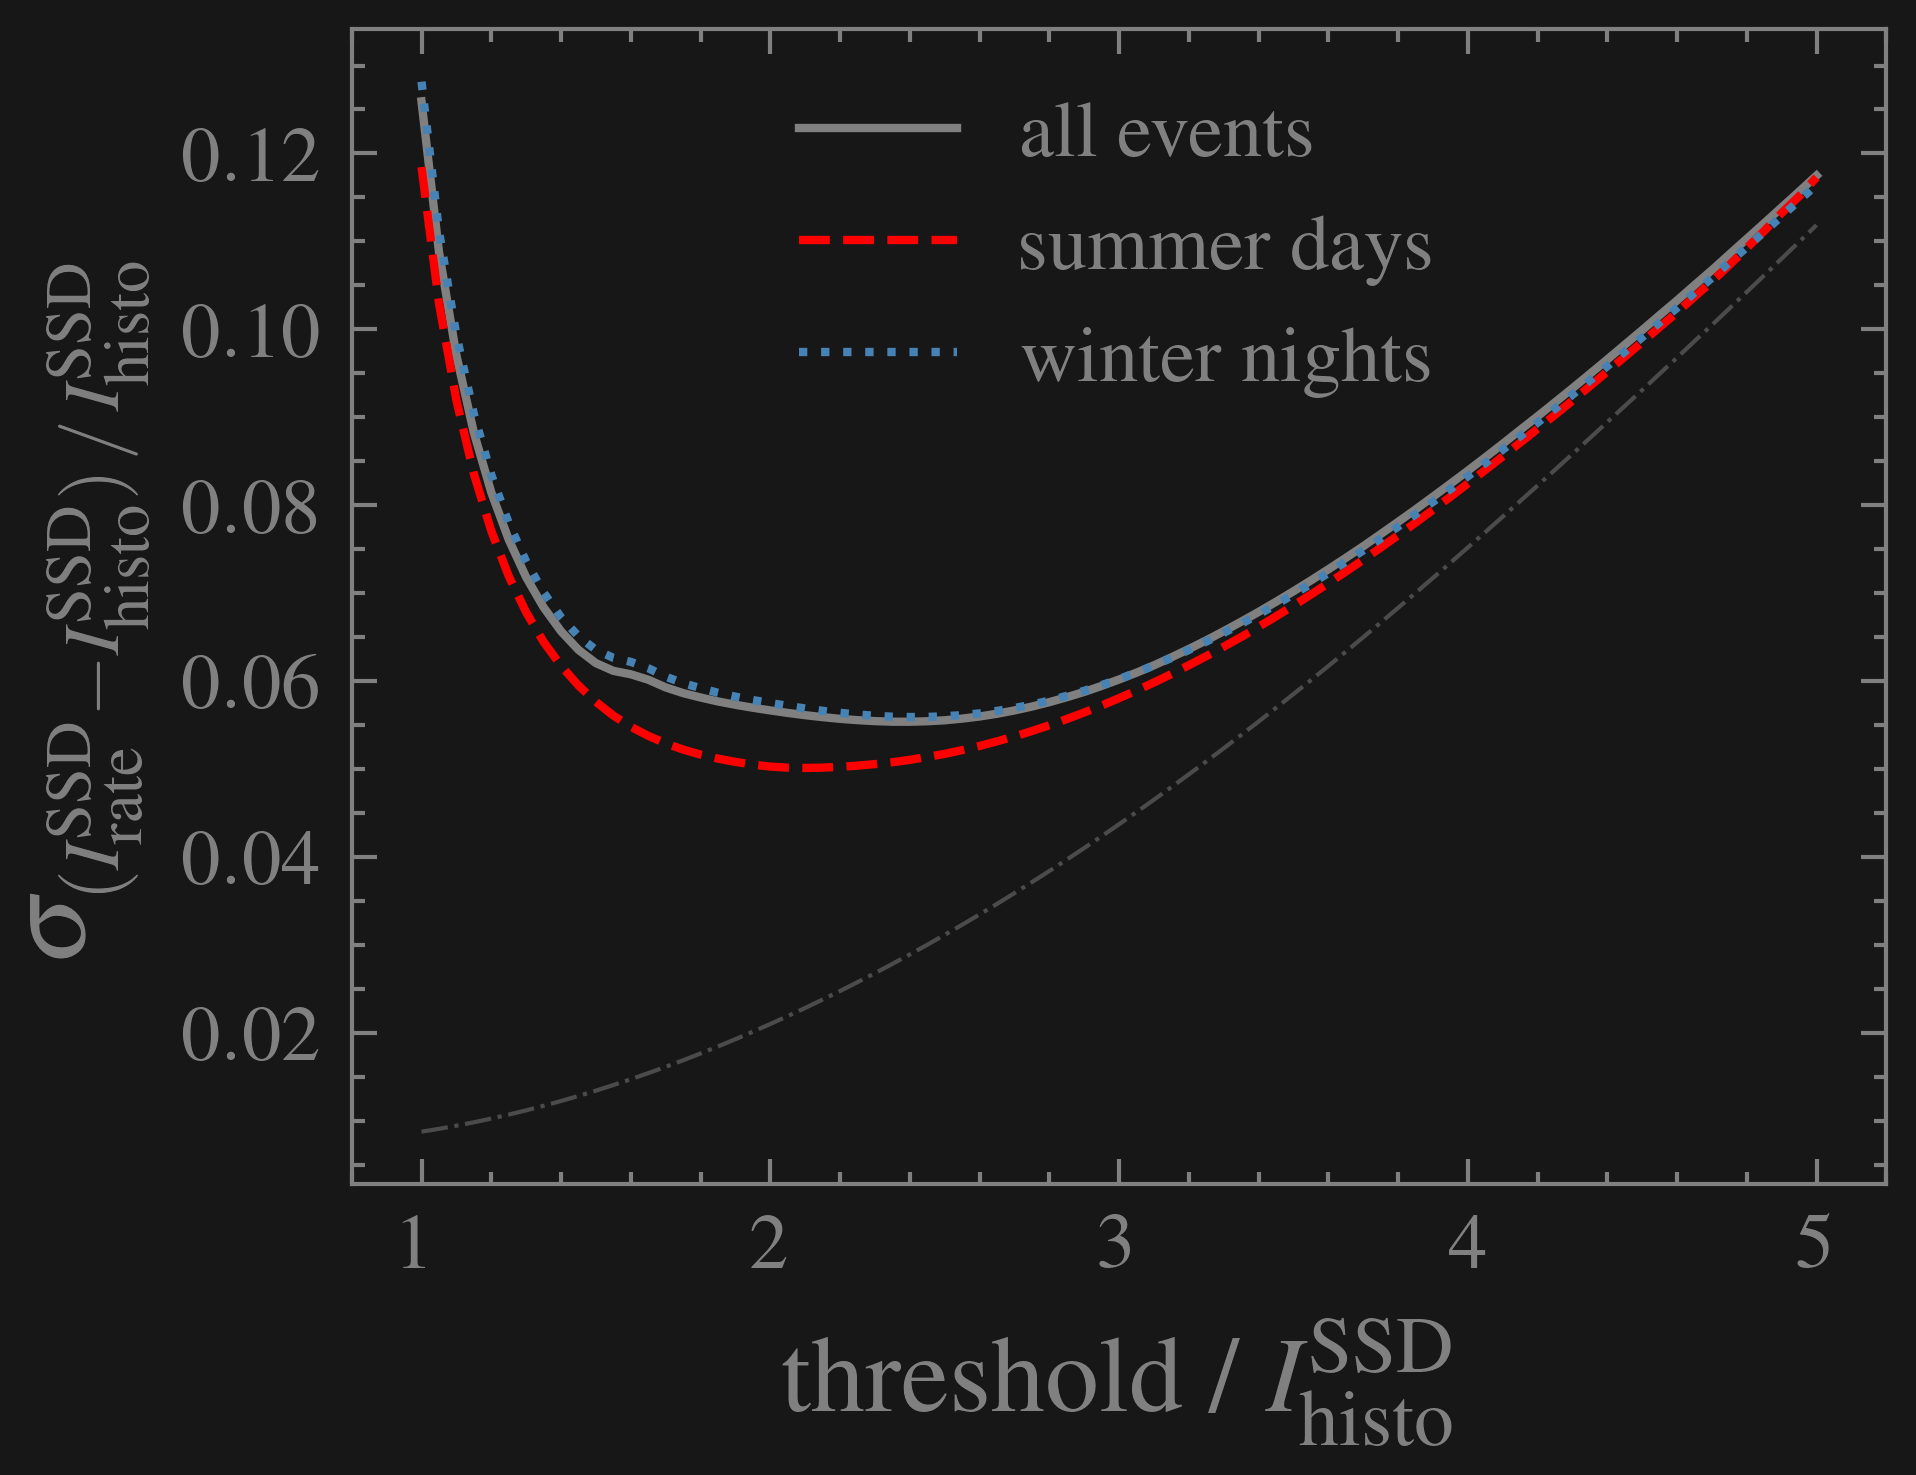

In [ ]:
set_plt_style('double tex')

threshold, mean_rates = np.loadtxt('/cr/users/filip/Data/SDMonitHistos/mean_rates.txt', unpack=True)
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

biases, biases_summer, biases_winter = [], [], []
for station in stations:

    events = performance[performance['id'] == station]
    summer = performance_summer[performance_summer['id'] == station]
    winter = performance_winter[performance_winter['id'] == station]

    mip = events['mip'].values[0] if len(events) != 0 else np.nan
    mip_summer = summer['mip'].values[0] if len(summer) != 0 else np.nan
    mip_winter = winter['mip'].values[0] if len(winter) != 0 else np.nan

    if not np.isnan(mip): biases.append((events.iloc[0][2:].map(lambda _ : _[0]).values - mip) / mip)
    if not np.isnan(mip_summer): biases_summer.append((summer.iloc[0][2:].map(lambda _ : _[0]).values - mip_summer) / mip_summer)
    if not np.isnan(mip_winter): biases_winter.append((winter.iloc[0][2:].map(lambda _ : _[0]).values - mip_winter) / mip_winter)

biases, biases_summer, biases_winter = np.array(biases).T, np.array(biases_summer).T, np.array(biases_winter).T
bias, bias_summer, bias_winter = np.mean(biases, axis=1), np.mean(biases_summer, axis=1), np.mean(biases_winter, axis=1)
sigma_sys, sigma_summer, sigma_winter = np.std(biases, axis=1), np.std(biases_summer, axis=1), np.std(biases_winter, axis=1)
sigma_stat = 1/np.sqrt(mean_rates * 61)

# ax1.set_ylime(-0.05, 0.05)
ax1.plot(threshold, bias, label="all events")
ax1.plot(threshold, bias_summer, label="summer days")
ax1.plot(threshold, bias_winter, label="winter nights")
ax1.axhline(0, c='lightgray', ls='--', lw=1)
ax1.legend()

ax2.plot(threshold, np.sqrt(sigma_sys**2 + sigma_stat**2), label='all events')
ax2.plot(threshold, np.sqrt(sigma_summer**2 + sigma_stat**2), label='summer days')
ax2.plot(threshold, np.sqrt(sigma_winter**2 + sigma_stat**2), label='winter nights')
ax2.plot(threshold, sigma_stat, c='gray', lw=0.5, ls='-.', alpha=0.5)
ax2.legend()

ax1.set_ylim(-0.03, 0.03)
ax1.set_xlabel("threshold / $I^\mathrm{SSD}_\mathrm{histo}$")
ax2.set_xlabel("threshold / $I^\mathrm{SSD}_\mathrm{histo}$")
ax1.set_ylabel("$(I^\mathrm{SSD}_\mathrm{rate} - I^\mathrm{SSD}_\mathrm{histo})\,/\,I^\mathrm{SSD}_\mathrm{histo}$")
ax2.set_ylabel("$\sigma_{(I^\mathrm{SSD}_\mathrm{rate} - I^\mathrm{SSD}_\mathrm{histo})\,/\,I^\mathrm{SSD}_\mathrm{histo}}$")

plot.save(fig1, 'malargue_2024_04/bias')
plot.save(fig2, 'malargue_2024_04/std')
